# Importation des modules

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from skimage import data

from PIL.Image import *

from imageio import imread
import glob
from tqdm import tnrange
from tqdm.notebook import tqdm_notebook
import tqdm
import torch
from torchvision import datasets,transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torchvision.utils import save_image

import multiprocessing
import time

In [2]:
torch.cuda.is_available()

True

# Création du train_set et test_set


## Chargement du dataset

In [3]:
size = 60

In [4]:
deep = 3

In [5]:
def image_to_numpy(image) :
    n = len(image)
    image_bis = []
    for i in range (n) :
        image_bis.append([])
        for j in range(n) :
            image_bis[i].append(image[i][j][0])
    return np.array(image_bis)

In [6]:
list_images = []
list_labels = []

list_path = set()

path_imgs = "trans100_60/"

def select_unique_imgs():
    for image_path in tqdm_notebook(glob.glob(path_imgs + "*.png")):
        label = image_path.find('l')
        couche = image_path.find('c')
        id_image = image_path[:couche]
        label_image = int(image_path[label+1:couche])
        list_path.add((id_image, label_image))



def load_pictures(data_files):
    with multiprocessing.Pool() as p :
        res = list(tqdm.tqdm(p.imap(load_image3.load_img_from_path, data_files), total=len(data_files)))
    for lot_lab, lot_img in tqdm.tqdm(res, total=len(res)):
        list_images.append(lot_img)
        list_labels.append(lot_lab)

In [7]:
select_unique_imgs()

In [8]:
import load_image3


if __name__ ==  '__main__' : 
    load_pictures(list_path)

100%|█████████████████████████████████████████████████████████████████████████| 8868/8868 [00:00<00:00, 1773390.29it/s]


## Renumérotation des labels

nombre de classes :  95
répartition des labels :


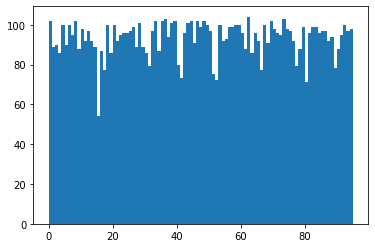

In [9]:
num_label = np.histogram(list_labels, bins=range(max(list_labels)+2))[0]
nouv_label = [-1]*(max(list_labels)+2)
compteur = 0
for i in range(max(list_labels)+1) :
    if num_label[i]>0 :
        nouv_label[i]=compteur
        compteur+=1
        
label_max = max(nouv_label)

num_classes = label_max+1

print("nombre de classes : ", num_classes)

nouv_list_labels = []
for i in range(len(list_labels)) :
    nouv_list_labels.append(nouv_label[list_labels[i]])

plt.hist(nouv_list_labels, bins=range(label_max +2))

print("répartition des labels :")

## Mélange et transformation pytorch du dataset en train_set et test_set

In [10]:
def shuffle_in_unison(list_images, list_labels):
    assert len(list_images) == len(list_labels)
    shuffled_list_images = np.empty(list_images.shape, dtype=list_images.dtype)
    shuffled_list_labels = np.empty(list_labels.shape, dtype=list_labels.dtype)
    permutation = np.random.permutation(len(list_images))
    for old_index, new_index in enumerate(permutation):
        shuffled_list_images[new_index] = list_images[old_index]
        shuffled_list_labels[new_index] = list_labels[old_index]
    return shuffled_list_images, shuffled_list_labels

In [11]:
def list_to_torch(list_images, list_labels) :
    n = len(list_images)
    
    torch_images=np.array([np.asarray(data) for data in list_images])
    torch_labels=np.array(list_labels)
    
    torch_images, torch_labels=shuffle_in_unison(torch_images, torch_labels)
    
    torch_images = torch.from_numpy(torch_images).cuda()
    torch_labels = torch.from_numpy(torch_labels).cuda()
    
    train_set = torch.utils.data.TensorDataset(torch_images[:int(0.8*n)],torch_labels[:int(0.8*n)])
    test_set = torch.utils.data.TensorDataset(torch_images[int(0.8*n):],torch_labels[int(0.8*n):])
    
    return train_set, test_set

In [12]:
train_set, test_set = list_to_torch(list_images, nouv_list_labels)

# Définition et entraînement du réseau de neurones

In [14]:
def train_epoch(net, train_set, opt, criterion, batch_size):
    net.train()
    trainloader = torch.utils.data.DataLoader(train_set, batch_size)
    for x_batch, y_batch in trainloader :
        opt.zero_grad()
        # Forward
        y_pred = net(x_batch.float())
        y_batch = y_batch.long()
        # Compute diff
        loss = criterion(y_pred, y_batch)
        # Compute gradients
        loss.backward()
        # update weights
        opt.step()

def accuracy(net, dataset):
    net.eval()
    correct = 0
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    for x_batch, y_batch in trainloader :
        y_pred = net(x_batch.float())
        y_pred = torch.argmax(y_pred).int()
        if int(y_pred)==int(y_batch[0]) :
            correct+=1
    return correct/len(dataset)

In [15]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()

        #first scale :
        self.first_scale = nn.Conv2d(in_planes, kernel_1_x, kernel_size=1, padding=0)

        #second scale :
        second_scale_1 = nn.Conv2d(in_planes, kernel_3_in, kernel_size=1, padding=0)
        second_scale_2 = nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1)

        self.second_scale = nn.Sequential(second_scale_1,second_scale_2)

        #third scale :
        third_scale_1 = nn.Conv2d(in_planes, kernel_5_in, kernel_size=1, padding=0)
        third_scale_2 = nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2)

        self.third_scale = nn.Sequential(third_scale_1,third_scale_2)


        #forth scale :
        forth_scale_1 = nn.MaxPool2d(3,1, padding=1)
        forth_scale_2 = nn.Conv2d(in_planes, pool_planes, kernel_size=1, padding=0)   
        
        self.forth_scale = nn.Sequential(forth_scale_1,forth_scale_2)


    def forward(self, x):
      
      x1 = self.first_scale(x)
      x2 = self.second_scale(x)
      x3 = self.third_scale(x)
      x4 = self.forth_scale(x)
        
      res = torch.cat([x1,x2,x3,x4],1)
      return res


class GoogLeNet(nn.Module):
    def __init__(self, input_dim=9):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(input_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.layer1 = Inception(192,  64,  96, 128, 16, 32, 32)
        
        self.layer2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.layer3 = Inception(480, 192,  96, 208, 16,  48,  64)
        
        #classifier
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.linear = nn.Linear(512, 655)
        

    def forward(self, x):
        
        x = self.pre_layers(x)
        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.max_pool(x)
        x = self.layer3(x)
        x = self.max_pool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


In [16]:
ggnet_trained = GoogLeNet(3).cuda()
ggnet_trained.load_state_dict(torch.load("poids_models/ggnet_sup150_60_rgb.ckpt"))

<All keys matched successfully>

In [17]:
net = GoogLeNet(3).cuda()

In [18]:
params_trained = ggnet_trained.named_parameters()
params = net.named_parameters()

dict_params_trained = dict(params_trained)
dict_params = dict(params)


for name in dict_params :
    if name[0:6]=="linear" :
        break
    dict_params[name].data.copy_(dict_params_trained[name])
    dict_params[name].data.requires_grad = False

C:\Users\stani\anaconda3\envs\modal\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  app.launch_new_instance()


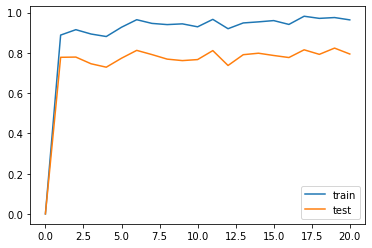

accuracy : 0.794250281848929
temps d'exécution : 17.63090266784032 min


In [19]:
debut = time.time()

epochs = 20
criterion = nn.CrossEntropyLoss()

opt = torch.optim.Adam(net.parameters(),lr=1e-3,betas=(0.9, 0.999),eps=1e-08)

preci_train = []
preci_test = []

preci_train.append(accuracy(net, train_set))
preci_test.append(accuracy(net, test_set))

for i in tnrange(epochs) :
    train_epoch(net, train_set, opt, criterion, batch_size=25)
    preci_train.append(accuracy(net, train_set))
    preci_test.append(accuracy(net, test_set))

plt.plot(range(len(preci_train)), preci_train, label = "train")
plt.plot(range(len(preci_test)), preci_test, label =  "test")
plt.legend()
plt.show()

print("accuracy :", accuracy(net, test_set)) 

fin = time.time()
duree = fin-debut
print("temps d'exécution :", duree/60, "min")